### Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import os
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import time
from matplotlib.image import imread

In [2]:
import importlib
import Utils_models
importlib.reload(Utils_models)
from Utils_models import *

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Load Model Classes

In [4]:
import Models_Classes
importlib.reload(Models_Classes)
from Models_Classes import MLPBaseline
from Models_Classes import EncDec_Noise
from Models_Classes import EncDec_Noise_1
from Models_Classes import LSTM
from Models_Classes import LSTM_Pooling
from Models_Classes import TrajTransformer

### Initialize Dataoader - Dataloader with Origin
# Load the dataloader with the origin for ploting information 
from Models_Classes import LoadCSV_to_Dataset_with_Origin

In [5]:
features_xy_cords = ['xCenter', 'yCenter']  # x and y coordinates
features_zones =    ['zone_zebra', 'zone_1', 'zone_2', 'zone_3']
features_ttc_123 =      ['ttc_1', 'ttc_2', 'ttc_3']
features_ttc_456 =      ['ttc_4', 'ttc_5', 'ttc_6']
features_ttc_789 =      ['ttc_7', 'ttc_8', 'ttc_9']
features_ttc = features_ttc_123 + features_ttc_456 + features_ttc_789

input_features = features_xy_cords   + features_zones  + features_ttc    # input all features
# input_features = features_xy_cords                                       # input only xy

output_features = features_xy_cords                                     # out
# dimensions
input_dim = len(input_features)     # 2 + 4 + 9 = 15
output_dim = len(output_features)    # 2

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
folder_path = r'C:\Users\yftac\Documents\00_Project_Afeka\ttc_calculation\13_data_tcc_flattened'

obs_input_len=8        # 8 history
fut_output_len=12       # 12 horizon
batch_size=64

dataset = LoadCSV_to_Dataset_with_Origin(folder_path, obs_input_len, fut_output_len, 
                             input_features, output_features)   # loads csv's

# split for train-test
train_size = int(0.8 * len(dataset)) # split_percentage = 0.8
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size],
                                           generator=torch.Generator().manual_seed(42))
# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=False) # for reproduecibility
test_dataloader = DataLoader(test_dataset,   batch_size, shuffle=False)

### Load saved models

In [7]:
file_name_LSTM_Pooling = "LSTM_Pooling_xy_zone_ttc_epoch_140_h-h_8-12_pt1_pf1.2.pth"
model_LSTM_Pooling, checkpoint_LSTM_Pooling = load_model(file_name_LSTM_Pooling, 
                                                         LSTM_Pooling, device)

Loaded and switch to eval: LSTM_Pooling_xy_zone_ttc_epoch_140_h-h_8-12_pt1_pf1.2.pth


c:\Users\yftac\Documents\00_Project_Afeka\models\v2\Utils_models.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_name, map_location=device)

### Verify all recordingId are in test_dataset

In [8]:
# Verify all recordingId are in test_dataset
unique_recording_ids = set()
for idx in range(len(test_dataset)):
    origin = dataset.get_origin(test_dataset.indices[idx])
    unique_recording_ids.add(origin['recordingId'])
print("Unique recordingId values in test_dataset:", unique_recording_ids)
print("Total unique recordingId:", len(unique_recording_ids))
if len(unique_recording_ids) == 12: print("All 12 recordingId are present in the test_dataset :) :) :)")

Unique recordingId values in test_dataset: {18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}
Total unique recordingId: 12
All 12 recordingId are present in the test_dataset :) :) :)


### Access a sample and show its data and origin information

Total samples in train_dataset:   236378
Total samples in test_dataset:    59095

Sample index:                     0
obs shape:                        torch.Size([8, 15])
fut shape:                        torch.Size([12, 2])
origin info:                      {'recordingId': 23, 'trackId': 433, 'start_idx': 2, 'first_frame': 4452}
print data:
obs:
 tensor([[ 50.9864, -36.0780],
        [ 50.6259, -36.1031],
        [ 50.2860, -36.1457],
        [ 49.9584, -36.1945],
        [ 49.6433, -36.2441],
        [ 49.3419, -36.2938],
        [ 49.0453, -36.3411],
        [ 48.7477, -36.3984]])
fut:
 tensor([[ 48.4412, -36.4680],
        [ 48.1300, -36.5440],
        [ 47.8157, -36.6436],
        [ 47.4994, -36.7679],
        [ 47.2061, -36.8908],
        [ 46.9353, -36.9854],
        [ 46.6644, -37.0259],
        [ 46.3832, -37.0120],
        [ 46.0863, -36.9667],
        [ 45.7794, -36.9406],
        [ 45.4701, -36.9338],
        [ 45.1455, -36.9348]])
Predicted xy coords:
 [[ 48.53107  -36.41

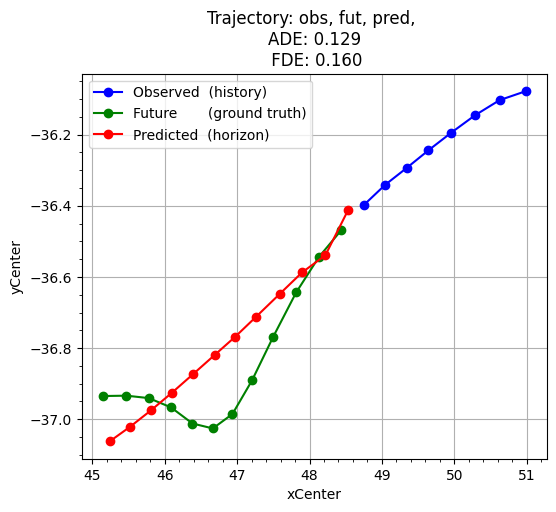

In [9]:
print('Total samples in train_dataset:  ', len(train_dataset))
print('Total samples in test_dataset:   ', len(test_dataset))
print()
sample_idx =   0
print("Sample index:                    ", sample_idx)
obs, fut = test_dataset[sample_idx]  
origin = dataset.get_origin(test_dataset.indices[sample_idx]) 
print("obs shape:                       ", obs.shape)
print("fut shape:                       ", fut.shape)
print("origin info:                     ", origin)
print('print data:')
print("obs:\n", obs[:, :2]) # print only the xy coordinates
print("fut:\n", fut)

# predict
with torch.no_grad():
    pred = model_LSTM_Pooling(obs.unsqueeze(0).to(device))
print("Predicted xy coords:\n", pred.squeeze(0)[:, :2].cpu().numpy())

obs_xy = obs[:, :2].cpu().numpy() if hasattr(obs, "cpu") else obs[:, :2]
fut_xy = fut[:, :2].cpu().numpy() if hasattr(fut, "cpu") else fut[:, :2]
pred_xy = pred.squeeze(0)[:, :2].cpu().numpy() if hasattr(pred, "cpu") else pred.squeeze(0)[:, :2]

# sample_ade = ade(pred_xy, fut_xy)
sample_ade = np.mean(np.linalg.norm(pred_xy - fut_xy, axis=1))
sample_fde = np.linalg.norm(pred_xy[-1] - fut_xy[-1])

plt.figure(figsize=(6, 5))
plt.plot(obs_xy[:, 0], obs_xy[:, 1], 'bo-',     label='Observed  (history)')
plt.plot(fut_xy[:, 0], fut_xy[:, 1], 'go-',     label='Future       (ground truth)')
plt.plot(pred_xy[:, 0], pred_xy[:, 1], 'ro-',   label='Predicted  (horizon)')
plt.legend()
plt.xlabel('xCenter')
plt.ylabel('yCenter')
plt.title(f'Trajectory: obs, fut, pred, \nADE: {sample_ade:.3f}\n FDE: {sample_fde:.3f}')
plt.grid(True)
plt.minorticks_on()
plt.show()

## Plot on Aerial image

### Load Images params and lists

In [10]:
# Specify the directory to load files from
directory = r'C:\Users\yftac\Documents\00_Project_Afeka\ttc_calculation\02_fps_degraded_data'
# Get a list of files in the directory
file_name_list = os.listdir(directory)
file_name_list

recordingId_list = file_name_list.copy()
for i in range(len(recordingId_list)):
    recordingId_list[i]=recordingId_list[i].replace('_fps_degraded_data.csv', '')
recordingId_list

orthoPxToMeter = 0.00814636091724502
scale_down_factor = 12

image_directory = r'C:\Users\yftac\Documents\00_Project_Afeka\inD\drone-dataset-tools-master\data'
# recordingId_list # list of recording 
# Get a list of image paths that match recordingId
image_paths = []
for recording_id in recordingId_list:
    for file in os.listdir(image_directory):
        if file.endswith('.png'): # get list of png images with relevant id's
            if recording_id in file:
                image_paths.append(os.path.join(image_directory, file))



In [11]:
def evaluate_model_for_visual_analysis(model, test_dataset, dataset, device, 
                                       filter_threshold_for_extremes, recordingId):
    model.eval()
    ade_list = []
    fde_list = []
    # Gather all obs, fut, and origin
    all_obs = []
    all_fut = []
    all_origin = []
    for idx in range(len(test_dataset)):
        obs, fut = test_dataset[idx]
        origin = dataset.get_origin(test_dataset.indices[idx])
        all_obs.append(obs)
        all_fut.append(fut)
        all_origin.append(origin)
    # Filter indices by chosen recordingId
    filtered_indices = [i for i, origin in enumerate(all_origin) if origin["recordingId"] == recordingId]
    origin_list_filtered = []
    pred_list_filtered = []
    obs_list_filtered = []
    fut_list_filtered = []
    # Apply prediction and evaluation only for filtered indices
    for idx in tqdm(filtered_indices, desc=f"Evaluating samples for recordingId {recordingId}"):
        obs = all_obs[idx]
        fut = all_fut[idx]
        origin = all_origin[idx]
        with torch.no_grad():
            pred = model(obs.unsqueeze(0).to(device))
        obs_xy = obs[:, :2].cpu().numpy() if hasattr(obs, "cpu") else obs[:, :2]
        fut_xy = fut[:, :2].cpu().numpy() if hasattr(fut, "cpu") else fut[:, :2]
        pred_xy = pred.squeeze(0)[:, :2].cpu().numpy() if hasattr(pred, "cpu") else pred.squeeze(0)[:, :2]
        ade = np.mean(np.linalg.norm(pred_xy - fut_xy, axis=1))
        # fde = np.linalg.norm(pred_xy[-1] - fut_xy[-1])
        ade_list.append(ade)
        # fde_list.append(fde)
        origin_list_filtered.append(origin)
        pred_list_filtered.append(pred_xy)
        obs_list_filtered.append(obs_xy)
        fut_list_filtered.append(fut_xy)
    mean_ade = np.mean(ade_list) if ade_list else None
    mean_fde = np.mean(fde_list) if fde_list else None
    # evaluation_dict = {
    #     "mean_ade": mean_ade,
    #     "mean_fde": mean_fde,
    #     "ade_list": np.array(ade_list),
    #     "fde_list": np.array(fde_list),
    #     "origins": origin_list,
    #     "pred": pred_list,
    #     "obs": obs_list,
    #     "fut": fut_list
    # }
    data_df = pd.DataFrame({                   #each row in df is a sample
        "ade": ade_list,
        # "fde": evaluation_dict["fde_list"],
        "origin": origin_list_filtered,
        "pred": pred_list_filtered,
        "obs": obs_list_filtered,
        "fut": fut_list_filtered
    })
    # evaluation_dict_extremes = distribution_evaluation_for_extremes(
    #     np.array(ade_list), np.array(fde_list), filter_threshold_for_extremes
    # )
    return data_df #, evaluation_dict, evaluation_dict_extremes

In [32]:
def plot_objects_on_aerial_image(data_df_to_plot, background_image, orthoPxToMeter, 
                                 scale_down_factor, zoom_in_act, recordingId):
    # load image data and shape
    image_height_px, image_width_px = background_image.shape[:2]
    height_width_ratio = image_height_px / image_width_px
    x_lim_0 = 0
    x_lim_1 = image_width_px
    y_lim_0 = image_height_px
    y_lim_1 = 0
    plt.figure(figsize=(image_width_px/100, image_height_px/100))
    extent = [0, x_lim_1, -y_lim_0, y_lim_1]
    plt.imshow(background_image, extent=extent, aspect='auto')
    # Plot each trajectory from data_df_to_plot
    for idx, row in data_df_to_plot.iterrows():
        obs_xy = row['obs']
        fut_xy = row['fut']
        pred_xy = row['pred']
        # Convert to px if needed (assuming meters, adjust if already px)
        obs_x_px = obs_xy[:, 0] / orthoPxToMeter / scale_down_factor
        obs_y_px = obs_xy[:, 1] / orthoPxToMeter / scale_down_factor
        fut_x_px = fut_xy[:, 0] / orthoPxToMeter / scale_down_factor
        fut_y_px = fut_xy[:, 1] / orthoPxToMeter / scale_down_factor
        pred_x_px = pred_xy[:, 0] / orthoPxToMeter / scale_down_factor
        pred_y_px = pred_xy[:, 1] / orthoPxToMeter / scale_down_factor
        plt.plot(obs_x_px, obs_y_px, 'bo-', label='Observed' if idx == data_df_to_plot.index[0] else "", markersize=1)
        plt.plot(fut_x_px, fut_y_px, 'go-', label='Future GT' if idx == data_df_to_plot.index[0] else "", markersize=1)
        plt.plot(pred_x_px, pred_y_px, 'ro-', label='Predicted' if idx == data_df_to_plot.index[0] else "", markersize=1, alpha=0.5)
    if zoom_in_act:
        zoom_x_min = 95
        delta_x = 890
        delta_y = delta_x * height_width_ratio
        zoom_x_max = zoom_x_min + delta_x
        zoom_y_min = -620
        zoom_y_max = delta_y + zoom_y_min
        plt.xlim(zoom_x_min, zoom_x_max)
        plt.ylim(zoom_y_min, zoom_y_max)
    plt.xlabel('X [px]', fontsize=14)
    plt.ylabel('Y [px]', fontsize=14)
    plt.title(f'Trajectories: obs, fut, pred\nRecordingId {recordingId}', fontsize=16)
    plt.legend(fontsize=12)
    plt.show()
    return

### Create plot data

In [23]:
recordingId=20
x=recordingId_list.index(str(recordingId))
background_image=imread(image_paths[x])
data_df = evaluate_model_for_visual_analysis(model_LSTM_Pooling, test_dataset, dataset, device, 
                                       filter_threshold_for_extremes=1, recordingId=recordingId)

Evaluating samples for recordingId 20: 100%|██████████| 3774/3774 [00:22<00:00, 168.17it/s]


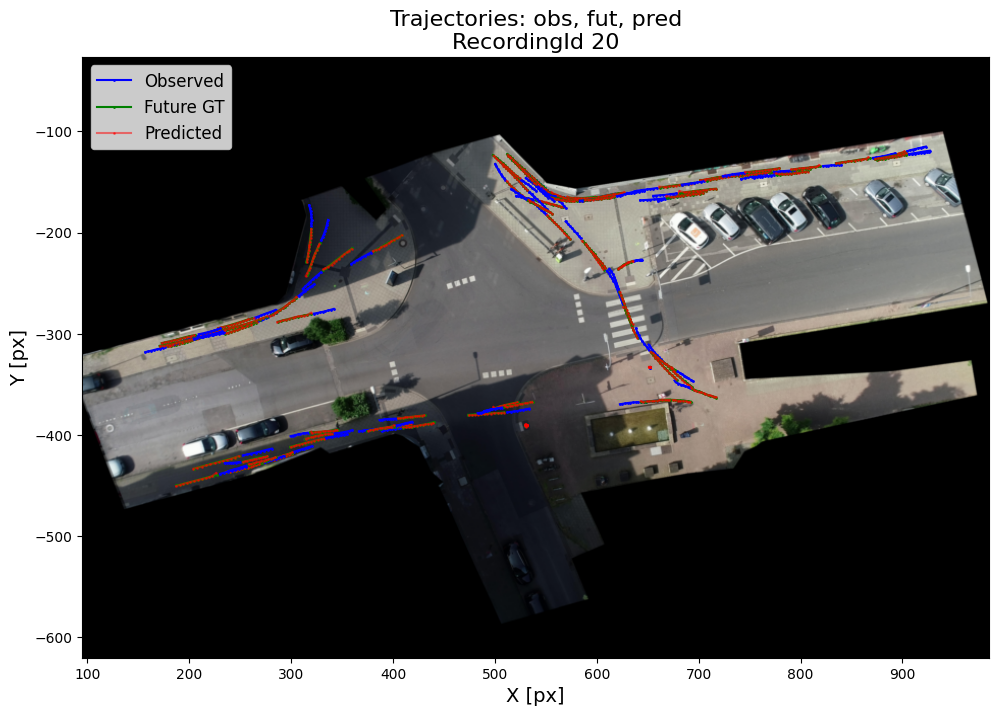

In [33]:
data_df_filtered = data_df[data_df['ade'] < 0.05]
# choose rows to plot
# rows_to_plot_list = [0, 5, 10, 88, 90]  # Example row indices to plot
rows_to_plot_list = range(0, len(data_df_filtered), 1)  # Plot all rows
data_df_to_plot = data_df_filtered.iloc[rows_to_plot_list]

plot_objects_on_aerial_image(data_df_to_plot, background_image, orthoPxToMeter, 
                                 scale_down_factor, True, 
                                 recordingId=recordingId)